# Single Classifier Workflow

In [16]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [17]:
from support import get_VSSG_data
from support import get_full_field_VSSG_data
from support import get_damaged_VSSG_data
from support import get_experimental_VSSG

In [18]:
from support_damage_detection import *

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

## Training and test data

In [20]:
# pristine data
df_simulated_pristine = get_VSSG_data("simulated", "pristine")
df_generated_pristine = get_VSSG_data("generated_small_u03", "pristine")
# damaged data
df_simulated_damaged = get_damaged_VSSG_data("simulated")
# experimental data
df_experimental = get_experimental_VSSG()

print(f"df_simulated_pristine: {df_simulated_pristine.shape}")
print(f"df_generated_pristine: {df_generated_pristine.shape}")
print(f"df_simulated_damaged: {df_simulated_damaged.shape}")
print(f"df_experimental: {df_experimental.shape}")

df_simulated_pristine: (1000, 31)
df_generated_pristine: (25000, 32)
df_simulated_damaged: (13504, 34)
df_experimental: (15, 34)


In [21]:
# define direction
default_direction = ["desc_x", "desc_y", "desc_xi"]

### Classifier definition

In [22]:
clf_pipeline = Pipeline([
    ('normalizer', Normalizer()),
    ('LOF', LocalOutlierFactor(n_neighbors=18, novelty=True))])

#### Training and testing with simulated data

X_train: (900, 27)
y_train: (900, 3)
X_test: (200, 27)
y_test: (200, 3)
----- LOF ----- 
Accuracy: 0.875
Balanced accuracy: 0.875
F1 Score: 0.8571428571428571
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       100
           1       1.00      0.75      0.86       100

    accuracy                           0.88       200
   macro avg       0.90      0.88      0.87       200
weighted avg       0.90      0.88      0.87       200

confusion matrix components:
True Positive (TP): 75
False Positive (FP): 0
False Negative (FN): 25
True Negative (TN): 100
-----  End of Report ----- 



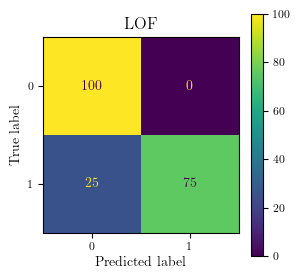

In [23]:
# assemble data
X_train, X_test, y_train, y_test = assemble_set1_OC(df_simulated_pristine,
                                                    df_simulated_damaged,
                                                    #df_generated_pristine,
                                                    direction=default_direction,
                                                    train_size=0.9,
                                                    balance_test_set=True,
                                                    random_seed=1)
# print data sizes
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# train classifer
clf = clf_pipeline.fit(X_train, y_train["damage_label"])
# get results
y_pred = clf.predict(X_test)
y_score = clf.decision_function(X_test)
clf_results = {"LOF": {"y_true": y_test, "y_pred": y_pred, "y_score": y_score}}
# visualize results
show_clf_result_metrics(clf_results, show_confusion_matrices=True)

In [24]:
classified_labels = get_classified_labels(y_test, y_pred, damage_params=True)
classified_labels["FN"]

,loadcase,y_pred,y_true,damage_state,source,x,y,radius
105,373,0,1,DS51,simulated,37.09,20.45,5.03
106,119,0,1,DS25,simulated,26.65,126.41,6.67
109,932,0,1,DS41,simulated,46.34,67.27,5.63
110,1,0,1,DS0,simulated,151.91,180.33,5.42
111,4,0,1,DS14,simulated,51.10,136.12,5.22
121,994,0,1,DS20,simulated,166.13,87.97,9.64
126,292,0,1,DS6,simulated,136.18,97.47,6.01
131,191,0,1,DS11,simulated,144.89,147.09,8.96
133,178,0,1,DS9,simulated,85.54,26.35,8.36
136,373,0,1,DS45,simulated,192.50,86.14,6.54


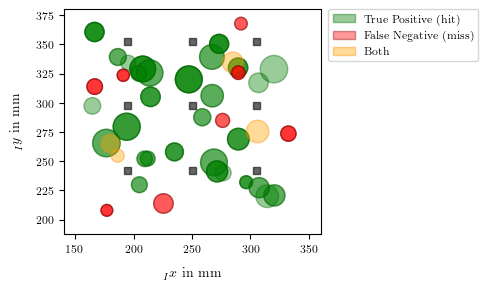

In [25]:
plot_classified_damages(classified_labels,
                        figure_width_cm=12,
                        figure_height_cm=None,
                        fn_extension="LOF_train_simulated", 
                        save_figure=False)

#### Training with generated data and testing with simulated data

X_train: (16160, 27)
y_train: (16160, 3)
X_test: (200, 27)
y_test: (200, 3)
----- LOF ----- 
Accuracy: 0.815
Balanced accuracy: 0.815
F1 Score: 0.7730061349693252
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       100
           1       1.00      0.63      0.77       100

    accuracy                           0.81       200
   macro avg       0.86      0.81      0.81       200
weighted avg       0.86      0.81      0.81       200

confusion matrix components:
True Positive (TP): 63
False Positive (FP): 0
False Negative (FN): 37
True Negative (TN): 100
-----  End of Report ----- 



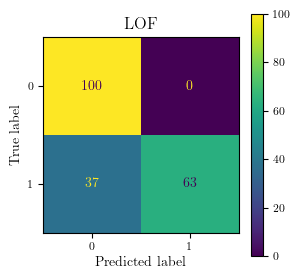

In [35]:
# assemble data
X_train, X_test, y_train, y_test = assemble_set4_OC(df_simulated_pristine,
                                                    df_simulated_damaged,
                                                    df_generated_pristine,
                                                    direction=default_direction,
                                                    test_size_damaged=100,
                                                    balance_test_set=True,
                                                    random_seed=2)
# print data sizes
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# train classifer
clf = clf_pipeline.fit(X_train, y_train["damage_label"])
# get results
y_pred = clf.predict(X_test)
y_score = clf.decision_function(X_test)
clf_results = {"LOF": {"y_true": y_test, "y_pred": y_pred, "y_score": y_score}}
# visualize results
show_clf_result_metrics(clf_results, show_confusion_matrices=True)

In [36]:
classified_labels = get_classified_labels(y_test, y_pred, damage_params=True)
classified_labels["FN"]

,loadcase,y_pred,y_true,damage_state,source,x,y,radius
100,590,0,1,DS20,simulated,166.13,87.97,9.64
103,185,0,1,DS13,simulated,94.10,61.83,6.85
111,667,0,1,DS6,simulated,136.18,97.47,6.01
115,434,0,1,DS41,simulated,46.34,67.27,5.63
118,151,0,1,DS51,simulated,37.09,20.45,5.03
122,985,0,1,DS22,simulated,75.83,73.39,5.28
123,635,0,1,DS24,simulated,167.44,39.86,8.62
124,596,0,1,DS9,simulated,85.54,26.35,8.36
126,444,0,1,DS0,simulated,151.91,180.33,5.42
129,49,0,1,DS36,simulated,149.66,138.32,5.77


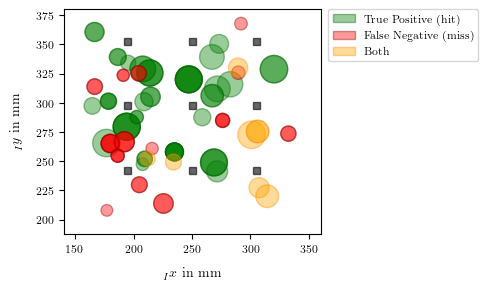

In [38]:
plot_classified_damages(classified_labels,
                        figure_width_cm=12,
                        figure_height_cm=None,
                        fn_extension="LOF_train_generated", 
                        save_figure=True)

#### Training with generated data and testing with experimental data

X_train: (25000, 27)
y_train: (25000, 3)
X_test: (15, 27)
y_test: (15, 3)
----- LOF ----- 
Accuracy: 0.9333333333333333
Balanced accuracy: 0.9
F1 Score: 0.9523809523809523
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.91      1.00      0.95        10

    accuracy                           0.93        15
   macro avg       0.95      0.90      0.92        15
weighted avg       0.94      0.93      0.93        15

confusion matrix components:
True Positive (TP): 10
False Positive (FP): 1
False Negative (FN): 0
True Negative (TN): 4
-----  End of Report ----- 



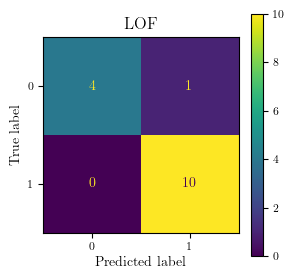

In [29]:
# classifier fails when trained with simulated data
#X_train, y_train = prepare_raw_data(df_simulated_pristine, direction=default_direction)
X_train, y_train = prepare_raw_data(df_generated_pristine.sample(frac=1.0), direction=default_direction)
X_test, y_test = prepare_raw_data(df_experimental, direction=default_direction)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# train classifer
clf = clf_pipeline.fit(X_train, y_train["damage_label"])
# get results
y_pred = clf.predict(X_test)
y_score = clf.decision_function(X_test)
clf_results = {"LOF": {"y_true": y_test, "y_pred": y_pred, "y_score": y_score}}
# visualize results
show_clf_result_metrics(clf_results, show_confusion_matrices=True)

In [30]:
classified_labels = get_classified_labels(y_test, y_pred, damage_params=True)
classified_labels["FP"]

,loadcase,y_pred,y_true,damage_state,source,x,y,radius
4,876,1,0,pristine,experimental,NaN,NaN,NaN


**Observations**
* Performance without Normlaizer is bad. 

#### Training with simulated data and testing with experimental data

X_train: (1000, 27)
y_train: (1000, 3)
X_test: (15, 27)
y_test: (15, 3)
----- LOF ----- 
Accuracy: 0.6666666666666666
Balanced accuracy: 0.5
F1 Score: 0.8
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.67      1.00      0.80        10

    accuracy                           0.67        15
   macro avg       0.33      0.50      0.40        15
weighted avg       0.44      0.67      0.53        15

confusion matrix components:
True Positive (TP): 10
False Positive (FP): 5
False Negative (FN): 0
True Negative (TN): 0
-----  End of Report ----- 



C:\Users\student\anaconda3\envs\IKLpy38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\student\anaconda3\envs\IKLpy38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\student\anaconda3\envs\IKLpy38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


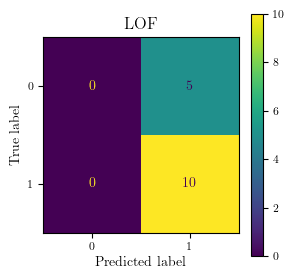

In [32]:
# classifier fails when trained with simulated data
#X_train, y_train = prepare_raw_data(df_simulated_pristine, direction=default_direction)
X_train, y_train = prepare_raw_data(df_simulated_pristine.sample(frac=1.0), direction=default_direction)
X_test, y_test = prepare_raw_data(df_experimental, direction=default_direction)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# train classifer
clf = clf_pipeline.fit(X_train, y_train["damage_label"])
# get results
y_pred = clf.predict(X_test)
y_score = clf.decision_function(X_test)
clf_results = {"LOF": {"y_true": y_test, "y_pred": y_pred, "y_score": y_score}}
# visualize results
show_clf_result_metrics(clf_results, show_confusion_matrices=True)

In [33]:
classified_labels = get_classified_labels(y_test, y_pred, damage_params=True)
classified_labels["FP"]

,loadcase,y_pred,y_true,damage_state,source,x,y,radius
0,814,1,0,pristine,experimental,NaN,NaN,NaN
1,984,1,0,pristine,experimental,NaN,NaN,NaN
2,985,1,0,pristine,experimental,NaN,NaN,NaN
3,999,1,0,pristine,experimental,NaN,NaN,NaN
4,876,1,0,pristine,experimental,NaN,NaN,NaN


### Effect of random reduction of OLCs on classification performance

* use balanced accuracy metric for imbalanced data set

In [12]:
default_direction = ["desc_x", "desc_y", "desc_xi"]
results = []

# loop in increments of 50 through the number of OLCs
rng = np.random.default_rng(0)
current_olcs = df_generated_pristine["loadcase"].unique()
rng.shuffle(current_olcs)
for n_to_remove in np.arange(1000, 0, -50):
    # train and test classifier
    X_train, y_train = prepare_raw_data(df_generated_pristine[df_generated_pristine["loadcase"].isin(current_olcs[:n_to_remove])],
                                        direction=default_direction)
    
    #X_train, y_train = prepare_raw_data(remove_n_olcs(df_generated_pristine, n_to_remove), direction=default_direction)
    X_test, y_test = prepare_raw_data(df_experimental, direction=default_direction)
    
    clf_pipeline = Pipeline([('normalizer', Normalizer()),
                             ('LOF', LocalOutlierFactor(n_neighbors=18, novelty=True))])
    # train classifer
    clf = clf_pipeline.fit(X_train, y_train["damage_label"])
    # get results
    y_pred = clf.predict(X_test)
    y_score = clf.decision_function(X_test)
    
    # log balanced accuracy score
    #n_olcs = 1000 - n_to_remove
    n_olcs = n_to_remove
    balanced_acc = balanced_accuracy_score(y_test["damage_label"], y_pred)
    F1_score = f1_score(y_test["damage_label"], y_pred, average="weighted")
    
    results.append({"n_olcs": n_olcs,
                    "Balanced accuracy": balanced_acc,
                    "F1 score": F1_score})
    
# plot balanced accuracy scores over number of considered OLCs
df_results = pd.DataFrame(results)


In [13]:
df_results

,n_olcs,Balanced accuracy,F1 score
0,1000,0.90,0.931217
1,950,0.90,0.931217
2,900,0.90,0.931217
3,850,0.90,0.931217
4,800,0.90,0.931217
5,750,0.90,0.931217
6,700,0.90,0.931217
7,650,0.90,0.931217
8,600,0.80,0.803828
9,550,0.80,0.803828


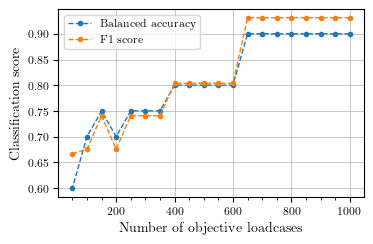

In [14]:
plot_score_over_n_olcs(df_results,
                       y_data = ["Balanced accuracy", "F1 score"],
                       figure_width_cm=10,
                       fn_extension="LOF",
                       save_figure=False)

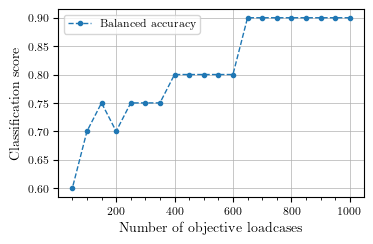

In [34]:
plot_score_over_n_olcs(df_results,
                       y_data = ["Balanced accuracy"],
                       figure_width_cm=10,
                       fn_extension="LOF",
                       save_figure=True)

**SOLVED** Why doe the scores oscillate? This should not be.. A reason could be that the loadcase removel always starts new with every iteration and sometimes (randomly) removes important loadcases and sometimes not so important ones, leading to a better classification result.
-> write function so that it first creates a random list of all loadcases and then iteration for iteration removes the loadcases. That way, once a loadcase is gone it can't be trained again. --> This approach worked well.

### Random reduction of OLCs and different u values

In [21]:
df_generated_pristine_u01 = get_VSSG_data("generated_small_u01", "pristine")
df_generated_pristine_u03 = get_VSSG_data("generated_small_u03", "pristine")
df_generated_pristine_u05 = get_VSSG_data("generated_small_u05", "pristine")
df_generated_pristine_u07 = get_VSSG_data("generated_small_u07", "pristine")
data_list = [df_generated_pristine_u01, df_generated_pristine_u03, df_generated_pristine_u05, df_generated_pristine_u07]

default_direction = ["desc_x", "desc_y", "desc_xi"]
results = []

for df_generated_pristine, u in zip(data_list, ["0.1", "0.3", "0.5", "0.7"]):
    # loop in increments of 50 through the number of OLCs
    rng = np.random.default_rng(0)
    current_olcs = df_generated_pristine["loadcase"].unique()
    rng.shuffle(current_olcs)
    for n_to_remove in np.arange(1000, 0, -50):
        # train and test classifier
        X_train, y_train = prepare_raw_data(df_generated_pristine[df_generated_pristine["loadcase"].isin(current_olcs[:n_to_remove])],
                                            direction=default_direction)

        #X_train, y_train = prepare_raw_data(remove_n_olcs(df_generated_pristine, n_to_remove), direction=default_direction)
        X_test, y_test = prepare_raw_data(df_experimental, direction=default_direction)

        clf_pipeline = Pipeline([('normalizer', Normalizer()),
                                 ('LOF', LocalOutlierFactor(n_neighbors=18, novelty=True))])
        # train classifer
        clf = clf_pipeline.fit(X_train, y_train["damage_label"])
        # get results
        y_pred = clf.predict(X_test)
        y_score = clf.decision_function(X_test)

        # log balanced accuracy score
        #n_olcs = 1000 - n_to_remove
        n_olcs = n_to_remove
        balanced_acc = balanced_accuracy_score(y_test["damage_label"], y_pred)
        F1_score = f1_score(y_test["damage_label"], y_pred)

        results.append({"u": u,
                        "n_olcs": n_olcs,
                        "Balanced accuracy": balanced_acc,
                        "F1 score": F1_score})

# plot balanced accuracy scores over number of considered OLCs
df_results = pd.DataFrame(results)


In [22]:
df_results[df_results["u"] == "0.1"]

,u,n_olcs,Balanced accuracy,F1 score
0,0.1,1000,0.5,0.0
1,0.1,950,0.5,0.0
2,0.1,900,0.5,0.0
3,0.1,850,0.5,0.0
4,0.1,800,0.5,0.0
5,0.1,750,0.5,0.0
6,0.1,700,0.5,0.0
7,0.1,650,0.5,0.0
8,0.1,600,0.5,0.0
9,0.1,550,0.5,0.0


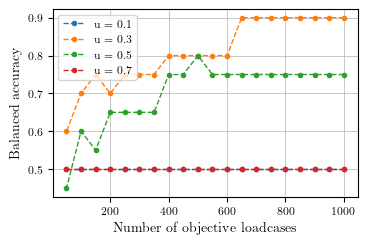

In [23]:
plot_score_over_n_olcs(df_results, y_data="Balanced accuracy")